# Boosting a decision stump

The goal of this notebook is to implement your own boosting module.

**Brace yourselves**! This is going to be a fun and challenging assignment.


* Use SFrames to do some feature engineering.
* Modify the decision trees to incorporate weights.
* Implement Adaboost ensembling.
* Use your implementation of Adaboost to train a boosted decision stump ensemble.
* Evaluate the effect of boosting (adding more decision stumps) on performance of the model.
* Explore the robustness of Adaboost to overfitting.

Let's get started!

In [128]:
import pandas as pd
import numpy as np
import json


# Load LendingClub dataset

We will be using the [LendingClub](https://www.lendingclub.com/) data. As discussed earlier, the [LendingClub](https://www.lendingclub.com/) is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors. 

Just like we did in previous assignments, we will build a classification model to predict whether or not a loan provided by lending club is likely to default.

Let us start by loading the data.

In [129]:
loans = pd.read_csv("/Users/amitpatel/Desktop/ML_Washington/WashingtonML/Classification/Week4/lending-club-data.csv")

/Users/amitpatel/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [130]:
loans.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1


## Modifying the target column

The target column (label column) of the dataset that we are interested in is called `bad_loans`. In this column **1** means a risky (bad) loan **0** means a safe  loan.

As in past assignments, in order to make this more intuitive and consistent with the lectures, we reassign the target to be:
* **+1** as a safe  loan, 
* **-1** as a risky (bad) loan. 

We put this in a new column called `safe_loans`.

In [131]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
del loans['bad_loans']

## Selecting features

In this assignment, we will be using a subset of features (categorical and numeric). The features we will be using are **described in the code comments** below. If you are a finance geek, the [LendingClub](https://www.lendingclub.com/) website has a lot more details about these features.

The features we will be using are described in the code comments below:

In [132]:
target = 'safe_loans'
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]              # monthly payment owed by the borrower
           

In [133]:
loans = loans[features + [target]]

In [134]:
loans.head()

,grade,term,home_ownership,emp_length,safe_loans
0,B,36 months,RENT,10+ years,1
1,C,60 months,RENT,< 1 year,-1
2,C,36 months,RENT,10+ years,1
3,C,36 months,RENT,10+ years,1
4,A,36 months,RENT,3 years,1


In [135]:
loans.shape

(122607, 5)

## One hot encoding

Then follow the following steps:

Apply one-hot encoding to loans. Your tool may have a function for one-hot encoding.
Load the JSON files into the lists train_idx and test_idx.
Perform train/validation split using train_idx and test_idx. In Pandas, for instance:

In [136]:
loans = pd.get_dummies(loans, dummy_na = True) # dummy_na = True to keep the nan columns.

In [137]:
loans.head()

,safe_loans,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,grade_nan,term_ 36 months,...,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,emp_length_nan
0,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,-1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0


## Test-Train Split

In [138]:
!ls

6-atp-I4EemJfgqR2HI2sA_0105449ffece4463b8b0c369c77de429_CLA08-NB01.ipynb.zip
CLA08-NB01.ipynb
CLA08-NB02.ipynb
SIyhqeI5EemJfgqR2HI2sA_201632dbff1e4b8dbe1e1d729da6ee27_CLA08-NB02.ipynb.zip
Week5_boosting_assignment_1.ipynb
Week5_boosting_decision_trees_assignment_2.ipynb
_1ccb9ec834e6f4b9afb46f4f5ab56402_module-8-assignment-1-train-idx.json.zip
_1ccb9ec834e6f4b9afb46f4f5ab56402_module-8-assignment-1-validation-idx.json.zip
_1ccb9ec834e6f4b9afb46f4f5ab56402_module-8-assignment-2-test-idx.json.zip
_1ccb9ec834e6f4b9afb46f4f5ab56402_module-8-assignment-2-train-idx.json.zip
boosting-annotated.pdf
module-8-assignment-1-train-idx.json
module-8-assignment-1-validation-idx.json
module-8-assignment-2-test-idx.json
module-8-assignment-2-train-idx.json


In [139]:
# Read the index for the train data
with open('module-8-assignment-2-train-idx.json', 'r') as filehandle:
    train_index = json.load(filehandle)

In [140]:
train_data = loans.iloc[train_index]

In [141]:
train_data.shape

(37224, 29)

In [142]:
# Read the index for the train data
with open('module-8-assignment-2-test-idx.json', 'r') as filehandle:
    test_index = json.load(filehandle)

In [143]:
test_data = loans.iloc[test_index]

In [144]:
test_data.shape

(9284, 29)

# Weighted decision trees

Let's modify our decision tree code from Module 5 to support weighting of individual data points.

### Weighted error definition

Consider a model with $N$ data points with:
* Predictions $\hat{y}_1 ... \hat{y}_n$ 
* Target $y_1 ... y_n$ 
* Data point weights $\alpha_1 ... \alpha_n$.

Then the **weighted error** is defined by:
$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \frac{\sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}]}{\sum_{i=1}^{n} \alpha_i}
$$
where $1[y_i \neq \hat{y_i}]$ is an indicator function that is set to $1$ if $y_i \neq \hat{y_i}$.


### Write a function to compute weight of mistakes

Write a function that calculates the weight of mistakes for making the "weighted-majority" predictions for a dataset. The function accepts two inputs:
* `labels_in_node`: Targets $y_1 ... y_n$ 
* `data_weights`: Data point weights $\alpha_1 ... \alpha_n$

We are interested in computing the (total) weight of mistakes, i.e.
$$
\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}].
$$
This quantity is analogous to the number of mistakes, except that each mistake now carries different weight. It is related to the weighted error in the following way:
$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \frac{\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\sum_{i=1}^{n} \alpha_i}
$$

The function **intermediate_node_weighted_mistakes** should first compute two weights: 
 * $\mathrm{WM}_{-1}$: weight of mistakes when all predictions are $\hat{y}_i = -1$ i.e $\mathrm{WM}(\mathbf{\alpha}, \mathbf{-1}$)
 * $\mathrm{WM}_{+1}$: weight of mistakes when all predictions are $\hat{y}_i = +1$ i.e $\mbox{WM}(\mathbf{\alpha}, \mathbf{+1}$)
 
 where $\mathbf{-1}$ and $\mathbf{+1}$ are vectors where all values are -1 and +1 respectively.
 
After computing $\mathrm{WM}_{-1}$ and $\mathrm{WM}_{+1}$, the function **intermediate_node_weighted_mistakes** should return the lower of the two weights of mistakes, along with the class associated with that weight. We have provided a skeleton for you with `YOUR CODE HERE` to be filled in several places.

In [145]:
def intermediate_node_weighted_mistakes(labels_in_node, data_weights):
    labels_in_node = np.array(labels_in_node)
    data_weights = np.array(data_weights)
    # Sum the weights of all entries with label +1
    total_weight_positive = sum(data_weights[labels_in_node == +1])
    
    # Weight of mistakes for predicting all -1's is equal to the sum above
    ### YOUR CODE HERE
    weighted_mistakes_all_negative = total_weight_positive
    
    # Sum the weights of all entries with label -1
    ### YOUR CODE HERE
    total_weight_negative = sum(data_weights[labels_in_node == -1])
    
    # Weight of mistakes for predicting all +1's is equal to the sum above
    ### YOUR CODE HERE
    weighted_mistakes_all_positive = total_weight_negative
    
    # Return the tuple (weight, class_label) representing the lower of the two weights
    #    class_label should be an integer of value +1 or -1.
    # If the two weights are identical, return (weighted_mistakes_all_positive,+1)
    ### YOUR CODE HERE
    if weighted_mistakes_all_negative < weighted_mistakes_all_positive:
        return (weighted_mistakes_all_negative, -1)
    else:
        return (weighted_mistakes_all_positive, +1)

**Checkpoint:** Test your **intermediate_node_weighted_mistakes** function, run the following cell:

In [146]:
example_labels = np.array([-1, -1, 1, 1, 1])
example_data_weights = np.array([1., 2., .5, 1., 1.])
if intermediate_node_weighted_mistakes(example_labels, example_data_weights) == (2.5, -1):
    print('Test passed!')
else:
    print('Test failed... try again!')

Test passed!


Recall that the **classification error** is defined as follows:
$$
\mbox{classification error} = \frac{\mbox{# mistakes}}{\mbox{# all data points}}
$$

**Quiz Question:** If we set the weights $\mathbf{\alpha} = 1$ for all data points, how is the weight of mistakes $\mbox{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})$ related to the `classification error`?

### Function to pick best feature to split on

We continue modifying our decision tree code from the earlier assignment to incorporate weighting of individual data points. The next step is to pick the best feature to split on.

The **best_splitting_feature** function is similar to the one from the earlier assignment with two minor modifications:
  1. The function **best_splitting_feature** should now accept an extra parameter `data_weights` to take account of weights of data points.
  2. Instead of computing the number of mistakes in the left and right side of the split, we compute the weight of mistakes for both sides, add up the two weights, and divide it by the total weight of the data.
  
Complete the following function. Comments starting with `DIFFERENT HERE` mark the sections where the weighted version differs from the original implementation.

In [147]:
def best_splitting_feature(data, features, target, data_weights):
    
    # These variables will keep track of the best feature and the corresponding error
    best_feature = None
    best_error = float('+inf') 
    num_points = float(len(data))

    # Loop through each feature to consider splitting on that feature
    for feature in features:
        
        # The left split will have all data points where the feature value is 0
        # The right split will have all data points where the feature value is 1
        left_split = data[data[feature] == 0]
        right_split = data[data[feature] == 1]
        
        # Apply the same filtering to data_weights to create left_data_weights, right_data_weights
        ## YOUR CODE HERE
        left_data_weights = data_weights[data[feature] == 0]
        right_data_weights = data_weights[data[feature] == 1]
                    
        # DIFFERENT HERE
        # Calculate the weight of mistakes for left and right sides
        ## YOUR CODE HERE
        left_weighted_mistakes, left_class = intermediate_node_weighted_mistakes(left_split[target],left_data_weights)
        right_weighted_mistakes, right_class = intermediate_node_weighted_mistakes(right_split[target],right_data_weights)
        
        # DIFFERENT HERE
        # Compute weighted error by computing
        #  ( [weight of mistakes (left)] + [weight of mistakes (right)] ) / [total weight of all data points]
        ## YOUR CODE HERE
        error = (left_weighted_mistakes + right_weighted_mistakes)/sum(data_weights)
        
        # If this is the best error we have found so far, store the feature and the error
        if error < best_error:
            best_feature = feature
            best_error = error
    
    # Return the best feature we found
    return best_feature

**Checkpoint:** Now, we have another checkpoint to make sure you are on the right track.

** Taking the columns of the dataframe after the hot-one encoding **

In [148]:
# Taking the columns of the dataframe after the hot-one encoding
new_features = loans.drop('safe_loans',1).columns

In [149]:
example_data_weights = np.array(len(train_data)* [1.5])
print(best_splitting_feature(train_data, new_features, target, example_data_weights))
if best_splitting_feature(train_data, new_features, target, example_data_weights) == 'term_ 36 months':
    print('Test passed!')
else:
    print('Test failed... try again!')

term_ 36 months
Test passed!


**Very Optional**. Relationship between weighted error and weight of mistakes

By definition, the weighted error is the weight of mistakes divided by the weight of all data points, so
$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \frac{\sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}]}{\sum_{i=1}^{n} \alpha_i} = \frac{\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\sum_{i=1}^{n} \alpha_i}.
$$

In the code above, we obtain $\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}})$ from the two weights of mistakes from both sides, $\mathrm{WM}(\mathbf{\alpha}_{\mathrm{left}}, \mathbf{\hat{y}}_{\mathrm{left}})$ and $\mathrm{WM}(\mathbf{\alpha}_{\mathrm{right}}, \mathbf{\hat{y}}_{\mathrm{right}})$. First, notice that the overall weight of mistakes $\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})$ can be broken into two weights of mistakes over either side of the split:
$$
\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})
= \sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}]
= \sum_{\mathrm{left}} \alpha_i \times 1[y_i \neq \hat{y_i}]
 + \sum_{\mathrm{right}} \alpha_i \times 1[y_i \neq \hat{y_i}]\\
= \mathrm{WM}(\mathbf{\alpha}_{\mathrm{left}}, \mathbf{\hat{y}}_{\mathrm{left}}) + \mathrm{WM}(\mathbf{\alpha}_{\mathrm{right}}, \mathbf{\hat{y}}_{\mathrm{right}})
$$
We then divide through by the total weight of all data points to obtain $\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}})$:
$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}})
= \frac{\mathrm{WM}(\mathbf{\alpha}_{\mathrm{left}}, \mathbf{\hat{y}}_{\mathrm{left}}) + \mathrm{WM}(\mathbf{\alpha}_{\mathrm{right}}, \mathbf{\hat{y}}_{\mathrm{right}})}{\sum_{i=1}^{n} \alpha_i}
$$

### Building the tree

With the above functions implemented correctly, we are now ready to build our decision tree. Recall from the previous assignments that each node in the decision tree is represented as a dictionary which contains the following keys:

    { 
       'is_leaf'            : True/False.
       'prediction'         : Prediction at the leaf node.
       'left'               : (dictionary corresponding to the left tree).
       'right'              : (dictionary corresponding to the right tree).
       'features_remaining' : List of features that are posible splits.
    }
    
Let us start with a function that creates a leaf node given a set of target values:

In [150]:
def create_leaf(target_values, data_weights):
    
    # Create a leaf node
    leaf = {'splitting_feature' : None,
            'is_leaf': True}
    
    # Computed weight of mistakes.
    weighted_error, best_class = intermediate_node_weighted_mistakes(target_values, data_weights)
    # Store the predicted class (1 or -1) in leaf['prediction']
    leaf['prediction'] = best_class ## YOUR CODE HERE
    
    return leaf 

We provide a function that learns a weighted decision tree recursively and implements 3 stopping conditions:
1. All data points in a node are from the same class.
2. No more features to split on.
3. Stop growing the tree when the tree depth reaches **max_depth**. 

In [151]:
def weighted_decision_tree_create(data, features, target, data_weights, current_depth = 1, max_depth = 10):
    remaining_features = list(features[:]) # Make a copy of the features.
    target_values = data[target]
    print("--------------------------------------------------------------------")
    print("Subtree, depth = %s (%s data points)." % (current_depth, len(target_values)))

    # Stopping condition 1. Error is 0.
    if intermediate_node_weighted_mistakes(target_values, data_weights)[0] <= 1e-15:
        print("Stopping condition 1 reached.")
        return create_leaf(target_values, data_weights)
    
    # Stopping condition 2. No more features.
    if remaining_features == []:
        print("Stopping condition 2 reached.")
        return create_leaf(target_values, data_weights)    
    
    # Additional stopping condition (limit tree depth)
    if current_depth > max_depth:
        print("Reached maximum depth. Stopping for now.")
        return create_leaf(target_values, data_weights)
    
    splitting_feature = best_splitting_feature(data, features, target, data_weights)
    remaining_features.remove(splitting_feature)
        
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    
    left_data_weights = data_weights[data[splitting_feature] == 0]
    right_data_weights = data_weights[data[splitting_feature] == 1]
    
    print("Split on feature %s. (%s, %s)" % (\
              splitting_feature, len(left_split), len(right_split)))

    # Create a leaf node if the split is "perfect"
    if len(left_split) == len(data):
        print("Creating leaf node.")
        return create_leaf(left_split[target], data_weights)
    if len(right_split) == len(data):
        print("Creating leaf node.")
        return create_leaf(right_split[target], data_weights)
    
    # Repeat (recurse) on left and right subtrees
    left_tree = weighted_decision_tree_create(
        left_split, remaining_features, target, left_data_weights, current_depth + 1, max_depth)
    right_tree = weighted_decision_tree_create(
        right_split, remaining_features, target, right_data_weights, current_depth + 1, max_depth)
    
    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}

Here is a recursive function to count the nodes in your tree:

In [152]:
def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

Run the following test code to check your implementation. Make sure you get **'Test passed'** before proceeding.

In [153]:
example_data_weights = np.array([1.0 for i in range(len(train_data))])
small_data_decision_tree = weighted_decision_tree_create(train_data, new_features, target,
                                        example_data_weights, max_depth=2)
if count_nodes(small_data_decision_tree) == 7:
    print('Test passed!')
else:
    print('Test failed... try again!')
    print('Number of nodes found:', count_nodes(small_data_decision_tree))
    print('Number of nodes that should be there: 7' )

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Split on feature grade_A. (9122, 101)
--------------------------------------------------------------------
Subtree, depth = 3 (9122 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (101 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Split on feature grade_D. (23300, 4701)
--------------------------------------------------------------------
Subtree, depth = 3 (23300 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (4701 data po

Let us take a quick look at what the trained tree is like. You should get something that looks like the following

```
{'is_leaf': False,
    'left': {'is_leaf': False,
        'left': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
        'prediction': None,
        'right': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
        'splitting_feature': 'grade.A'
     },
    'prediction': None,
    'right': {'is_leaf': False,
        'left': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
        'prediction': None,
        'right': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
        'splitting_feature': 'grade.D'
     },
     'splitting_feature': 'term. 36 months'
}```

In [154]:
small_data_decision_tree

{'is_leaf': False,
 'left': {'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'splitting_feature': 'grade_A'},
 'prediction': None,
 'right': {'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'splitting_feature': 'grade_D'},
 'splitting_feature': 'term_ 36 months'}

### Making predictions with a weighted decision tree

We give you a function that classifies one data point. It can also return the probability if you want to play around with that as well.

In [155]:
def classify(tree, x, annotate = False):   
    # If the node is a leaf node.
    if tree['is_leaf']:
        if annotate: 
            print("At leaf, predicting %s" % tree['prediction'])
        return tree['prediction'] 
    else:
        # Split on feature.
        split_feature_value = list(x[tree['splitting_feature']])[0]
        if annotate: 
            print("Split on %s = %s" % (tree['splitting_feature'], split_feature_value))
        if split_feature_value == 0:
            return classify(tree['left'], x, annotate)
        else:
            return classify(tree['right'], x, annotate)

### Evaluating the tree

Now, we will write a function to evaluate a decision tree by computing the classification error of the tree on the given dataset.

Again, recall that the **classification error** is defined as follows:
$$
\mbox{classification error} = \frac{\mbox{# mistakes}}{\mbox{# all data points}}
$$

The function called **evaluate_classification_error** takes in as input:
1. `tree` (as described above)
2. `data` (an SFrame)

The function does not change because of adding data point weights.

In [156]:
def evaluate_classification_error(tree, data, target):
    # Apply the classify(tree, x) to each row in your data
    predictions = []
    for i in range(len(data)):
        predictions.append(classify(tree, data[i+0:i+1]))
    
    np.array(predictions)
    # Once you've made the predictions, calculate the classification error and return it
    mistakes_count = sum(predictions != np.array(data[target]))
    classification_error = mistakes_count/len(data)
    return classification_error
    

In [157]:
evaluate_classification_error(small_data_decision_tree, test_data,target)

0.3981042654028436

### Example: Training a weighted decision tree

To build intuition on how weighted data points affect the tree being built, consider the following:

Suppose we only care about making good predictions for the **first 10 and last 10 items** in `train_data`, we assign weights:
* 1 to the last 10 items 
* 1 to the first 10 items 
* and 0 to the rest. 

Let us fit a weighted decision tree with `max_depth = 2`.

In [158]:
# Assign weights
example_data_weights = np.array([1.] * 10 + [0.]*(len(train_data) - 20) + [1.] * 10)

# Train a weighted decision tree model.
small_data_decision_tree_subset_20 = weighted_decision_tree_create(train_data, new_features, target,
                         example_data_weights, max_depth=2)

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature home_ownership_RENT. (20514, 16710)
--------------------------------------------------------------------
Subtree, depth = 2 (20514 data points).
Split on feature grade_F. (19613, 901)
--------------------------------------------------------------------
Subtree, depth = 3 (19613 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (901 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 2 (16710 data points).
Split on feature grade_D. (13315, 3395)
--------------------------------------------------------------------
Subtree, depth = 3 (13315 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 3 (3395 data points).
Stoppin

In [159]:
example_data_weights = np.array([1.] * 10 + [0.]*(len(train_data) - 20) + [1.] * 10)

In [160]:
len(example_data_weights)

37224

In [161]:
len(train_data)

37224

Now, we will compute the classification error on the `subset_20`, i.e. the subset of data points whose weight is 1 (namely the first and last 10 data points).

In [162]:
subset_20 = train_data.head(10).append(train_data.tail(10))
evaluate_classification_error(small_data_decision_tree_subset_20, subset_20, target)

0.05

Now, let us compare the classification error of the model `small_data_decision_tree_subset_20` on the entire test set `train_data`:

In [163]:
evaluate_classification_error(small_data_decision_tree_subset_20, train_data, target)

0.48124865678057166

The model `small_data_decision_tree_subset_20` performs **a lot** better on `subset_20` than on `train_data`.

So, what does this mean?
* The points with higher weights are the ones that are more important during the training process of the weighted decision tree.
* The points with zero weights are basically ignored during training.

**Quiz Question**: Will you get the same model as `small_data_decision_tree_subset_20` if you trained a decision tree with only the 20 data points with non-zero weights from the set of points in `subset_20`?

# Implementing your own Adaboost (on decision stumps)

Now that we have a weighted decision tree working, it takes only a bit of work to implement Adaboost. For the sake of simplicity, let us stick with **decision tree stumps** by training trees with **`max_depth=1`**.

Recall from the lecture the procedure for Adaboost:

1\. Start with unweighted data with $\alpha_j = 1$

2\. For t = 1,...T:
  * Learn $f_t(x)$ with data weights $\alpha_j$
  * Compute coefficient $\hat{w}_t$:
     $$\hat{w}_t = \frac{1}{2}\ln{\left(\frac{1- \mbox{E}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\mbox{E}(\mathbf{\alpha}, \mathbf{\hat{y}})}\right)}$$
  * Re-compute weights $\alpha_j$:
     $$\alpha_j \gets \begin{cases}
     \alpha_j \exp{(-\hat{w}_t)} & \text{ if }f_t(x_j) = y_j\\
     \alpha_j \exp{(\hat{w}_t)} & \text{ if }f_t(x_j) \neq y_j
     \end{cases}$$
  * Normalize weights $\alpha_j$:
      $$\alpha_j \gets \frac{\alpha_j}{\sum_{i=1}^{N}{\alpha_i}} $$
  
Complete the skeleton for the following code to implement **adaboost_with_tree_stumps**. Fill in the places with `YOUR CODE HERE`.

In [164]:
from math import log
from math import exp

def adaboost_with_tree_stumps(data, features, target, num_tree_stumps):
    # start with unweighted data
    alpha = np.array([1.]*len(data))
    weights = []
    tree_stumps = []
    target_values = np.array(data[target])
    
    for t in range(num_tree_stumps):
        print('=====================================================')
        print('Adaboost Iteration %d' % t)
        print('=====================================================')
        # Learn a weighted decision tree stump. Use max_depth=1
        tree_stump = weighted_decision_tree_create(data, features, target, data_weights=alpha, max_depth=1)
        tree_stumps.append(tree_stump)
        
        # Make predictions
        predictions = []
        for i in range(len(data)):
            predictions.append(classify(tree_stump, data[i+0:i+1]))
        
        predictions = np.array(predictions)
        # Produce a Boolean array indicating whether
        # each data point was correctly classified
        is_correct = predictions == target_values
        is_wrong   = predictions != target_values
        
        # Compute weighted error
        # YOUR CODE HERE
        weighted_error = sum(alpha[is_wrong])/sum(alpha)
        
        # Compute model coefficient using weighted error
        # YOUR CODE HERE
        weight = 0.5 * np.log((1-weighted_error)/weighted_error)
        weights.append(weight)
        
        # Adjust weights on data point
        #adjustment = is_correct.apply(lambda is_correct : exp(-weight) if is_correct else exp(weight))
        adjustment = [np.exp(-weight) if val else exp(weight) for val in is_correct]
        
        # Scale alpha by multiplying by adjustment 
        # Then normalize data points weights
        ## YOUR CODE HERE 
        sum_alpha = sum(alpha)
        alpha = alpha*adjustment/sum_alpha
    
    return weights, tree_stumps

### Checking your Adaboost code

Train an ensemble of **two** tree stumps and see which features those stumps split on. We will run the algorithm with the following parameters:
* `train_data`
* `features`
* `target`
* `num_tree_stumps = 2`

In [165]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, new_features, target, num_tree_stumps=2)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.


In [166]:
y = np.array([1,2,3,4])
[ val**2 if val%2 ==0 else val for val in y ]

[1, 4, 3, 16]

In [167]:
def print_stump(tree,name = 'root'):
    split_name = tree['splitting_feature'] # split_name is something like 'term. 36 months'
    if split_name is None:
        print("(leaf, label: %s)" % tree['prediction'])
        return None
    #split_feature, split_value = split_name.split('.')
    print('                       root')
    print('         |---------------|----------------|')
    print('         |                                |')
    print('         |                                |')
    print('         |                                |')
    print('  [{0} == 0]{1}[{0} == 1]        '.format(split_name, ' '*(27-len(split_name))))
    print('         |                                |')
    print('         |                                |')
    print('         |                                |')
    print('    (%s)                 (%s)' \
        % (('leaf, label: ' + str(tree['left']['prediction']) if tree['left']['is_leaf'] else 'subtree'),
           ('leaf, label: ' + str(tree['right']['prediction']) if tree['right']['is_leaf'] else 'subtree')))

Here is what the first stump looks like:

In [168]:
print_stump(tree_stumps[0])

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [term_ 36 months == 0]            [term_ 36 months == 1]        
         |                                |
         |                                |
         |                                |
    (leaf, label: -1)                 (leaf, label: 1)


Here is what the next stump looks like:

In [169]:
print_stump(tree_stumps[1])

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [grade_A == 0]                    [grade_A == 1]        
         |                                |
         |                                |
         |                                |
    (leaf, label: -1)                 (leaf, label: 1)


In [170]:
print(stump_weights)

[0.15802933659263743, 0.17682363293605327]


If your Adaboost is correctly implemented, the following things should be true:

* `tree_stumps[0]` should split on **term. 36 months** with the prediction -1 on the left and +1 on the right.
* `tree_stumps[1]` should split on **grade.A** with the prediction -1 on the left and +1 on the right.
* Weights should be approximately `[0.158, 0.177]` 

**Reminders**
- Stump weights ($\mathbf{\hat{w}}$) and data point weights ($\mathbf{\alpha}$) are two different concepts.
- Stump weights ($\mathbf{\hat{w}}$) tell you how important each stump is while making predictions with the entire boosted ensemble.
- Data point weights ($\mathbf{\alpha}$) tell you how important each data point is while training a decision stump.

In [171]:
def print_stump_rec(tree, name = 'root'):
    split_name = tree['splitting_feature'] # split_name is something like 'term. 36 months'
    if split_name is None:
        print("(leaf, label: %s)" % tree['prediction'])
        return None
    #split_feature, split_value = split_name.split('.')
    print('                       %s' % name)
    print('                         |')
    print('                        | |')
    print('                       |   |')
    print('                      |     |')
    print('             [{0} == 0]    [{0} == 1]    '.format(split_name))
    print('                     |       |')
    print('                    |         |')
    print('                    |          |')
    print('    (%s)                         (%s)' \
        % (('leaf, label: ' + str(tree['left']['prediction']) if tree['left']['is_leaf'] else print_stump_rec(tree['left'],tree['splitting_feature'])),
           ('leaf, label: ' + str(tree['right']['prediction']) if tree['right']['is_leaf'] else print_stump_rec(tree['right'],tree['splitting_feature']))))

In [172]:
print_stump_rec(tree_stumps[0])

                       root
                         |
                        | |
                       |   |
                      |     |
             [term_ 36 months == 0]    [term_ 36 months == 1]    
                     |       |
                    |         |
                    |          |
    (leaf, label: -1)                         (leaf, label: 1)


In [173]:
print_stump_rec(tree_stumps[1])

                       root
                         |
                        | |
                       |   |
                      |     |
             [grade_A == 0]    [grade_A == 1]    
                     |       |
                    |         |
                    |          |
    (leaf, label: -1)                         (leaf, label: 1)


### Training a boosted ensemble of 10 stumps

Let us train an ensemble of 10 decision tree stumps with Adaboost. We run the **adaboost_with_tree_stumps** function with the following parameters:
* `train_data`
* `features`
* `target`
* `num_tree_stumps = 10`

In [188]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, new_features, 
                                target, num_tree_stumps=10)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
---------------------------------

## Making predictions

Recall from the lecture that in order to make predictions, we use the following formula:
$$
\hat{y} = sign\left(\sum_{t=1}^T \hat{w}_t f_t(x)\right)
$$

We need to do the following things:
- Compute the predictions $f_t(x)$ using the $t$-th decision tree
- Compute $\hat{w}_t f_t(x)$ by multiplying the `stump_weights` with the predictions $f_t(x)$ from the decision trees
- Sum the weighted predictions over each stump in the ensemble.

Complete the following skeleton for making predictions:

In [175]:
stump_weights

[0.15802933659263743,
 0.17682363293605327,
 0.09311888971195705,
 0.0728888552581495,
 0.06706306914131716,
 0.06456916961613322,
 0.05456055779221647,
 0.04351093673354489,
 0.028988711500059067,
 0.0259625096913776]

In [176]:
tree_stumps

[{'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'splitting_feature': 'term_ 36 months'},
 {'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'splitting_feature': 'grade_A'},
 {'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'splitting_feature': 'grade_D'},
 {'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'splitting_feature': 'home_ownership_MORTGAGE'},
 {'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': -1, 'splitting

In [177]:
def predict_adaboost(stump_weights, tree_stumps, data):
    scores = np.array([0.]*len(data))
    
    for i, tree_stump in enumerate(tree_stumps):
        predictions = []
        for j in range(len(data)):
            predictions.append(classify(tree_stump, data[j+0:j+1]))
        
        # Accumulate predictions on scores array
        # YOUR CODE HERE
        scores = scores + (stump_weights[i] * np.array(predictions))
        
    #return scores.apply(lambda score : +1 if score > 0 else -1)
    return [+1 if score > 0 else -1 for score in scores]

In [178]:
predictions = predict_adaboost(stump_weights, tree_stumps, test_data)
accuracy = sum(np.array(predictions) == np.array(test_data[target]))/len(predictions)
print('Accuracy of 10-component ensemble = %s' % accuracy )

Accuracy of 10-component ensemble = 0.6203145196036192


Now, let us take a quick look what the `stump_weights` look like at the end of each iteration of the 10-stump ensemble:

In [179]:
stump_weights

[0.15802933659263743,
 0.17682363293605327,
 0.09311888971195705,
 0.0728888552581495,
 0.06706306914131716,
 0.06456916961613322,
 0.05456055779221647,
 0.04351093673354489,
 0.028988711500059067,
 0.0259625096913776]

**Quiz Question:** Are the weights monotonically decreasing, monotonically increasing, or neither?

**Reminder**: Stump weights ($\mathbf{\hat{w}}$) tell you how important each stump is while making predictions with the entire boosted ensemble.

# Performance plots

In this section, we will try to reproduce some of the performance plots dicussed in the lecture.

### How does accuracy change with adding stumps to the ensemble?

We will now train an ensemble with:
* `train_data`
* `features`
* `target`
* `num_tree_stumps = 30`

Once we are done with this, we will then do the following:
* Compute the classification error at the end of each iteration.
* Plot a curve of classification error vs iteration.

First, lets train the model.

In [181]:
# this may take a while... 
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, 
                                 new_features, target, num_tree_stumps=15)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
---------------------------------

Split on feature emp_length_nan. (35781, 1443)
--------------------------------------------------------------------
Subtree, depth = 2 (35781 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (1443 data points).
Reached maximum depth. Stopping for now.


### Computing training error at the end of each iteration

Now, we will compute the classification error on the **train_data** and see how it is reduced as trees are added.

In [183]:
# Commenting to not run this again as it takes a while to complete

# error_all = []
# for n in range(1, 15):
#     predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], train_data)
#     accuracy = sum(np.array(predictions) == np.array(train_data[target]))/len(predictions)
#     error = 1.0 - accuracy
#     error_all.append(error)
#     print("Iteration %s, training error = %s" % (n, error_all[n-1]))

Iteration 1, training error = 0.4216365785514722
Iteration 2, training error = 0.43343004513217276
Iteration 3, training error = 0.4000376101439931
Iteration 4, training error = 0.4000376101439931
Iteration 5, training error = 0.3847249086610789
Iteration 6, training error = 0.3846174511068128
Iteration 7, training error = 0.3827638082957232
Iteration 8, training error = 0.3846174511068128
Iteration 9, training error = 0.3827638082957232
Iteration 10, training error = 0.3844831291639802
Iteration 11, training error = 0.3827369439071566
Iteration 12, training error = 0.38144745325596385
Iteration 13, training error = 0.3815280464216635
Iteration 14, training error = 0.38056092843326883


### Visualizing training error vs number of iterations

We have provided you with a simple code snippet that plots classification error with the number of iterations. 

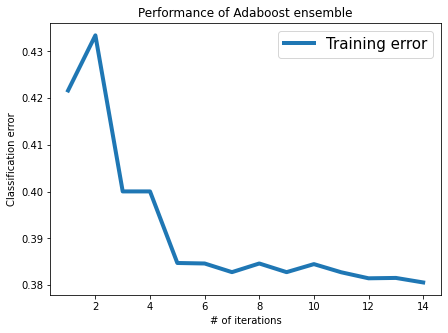

In [186]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,15), error_all, '-', linewidth=4.0, label='Training error')
plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.legend(loc='best', prop={'size':15})

plt.rcParams.update({'font.size': 16})

**Quiz Question**: Which of the following best describes a **general trend in accuracy** as we add more and more components? Answer based on the 30 components learned so far.

1. Training error goes down monotonically, i.e. the training error reduces with each iteration but never increases.
2. Training error goes down in general, with some ups and downs in the middle.
3. Training error goes up in general, with some ups and downs in the middle.
4. Training error goes down in the beginning, achieves the best error, and then goes up sharply.
5. None of the above


### Evaluation on the test data

Performing well on the training data is cheating, so lets make sure it works on the `test_data` as well. Here, we will compute the classification error on the `test_data` at the end of each iteration.

In [182]:
# Commenting to not run this again as it takes a while to complete

# test_error_all = []
# for n in range(1, 15):
#     predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], test_data)
#     accuracy = sum(np.array(predictions) == np.array(test_data[target]))/len(predictions)
#     error = 1.0 - accuracy
#     test_error_all.append(error)
#     print("Iteration %s, test error = %s" % (n, test_error_all[n-1]))

Iteration 1, test error = 0.4233089185695821
Iteration 2, test error = 0.4284791038345541
Iteration 3, test error = 0.3981042654028436
Iteration 4, test error = 0.3981042654028436
Iteration 5, test error = 0.37990090478242133
Iteration 6, test error = 0.38000861697544164
Iteration 7, test error = 0.37925463162429984
Iteration 8, test error = 0.38000861697544164
Iteration 9, test error = 0.37925463162429984
Iteration 10, test error = 0.37968548039638084
Iteration 11, test error = 0.37925463162429984
Iteration 12, test error = 0.37796208530805686
Iteration 13, test error = 0.37925463162429984
Iteration 14, test error = 0.37785437311503667


### Visualize both the training and test errors

Now, let us plot the training & test error with the number of iterations.

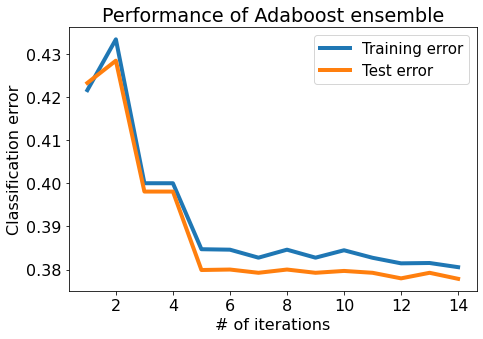

In [187]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,15), error_all, '-', linewidth=4.0, label='Training error')
plt.plot(range(1,15), test_error_all, '-', linewidth=4.0, label='Test error')

plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.rcParams.update({'font.size': 16})
plt.legend(loc='best', prop={'size':15})
plt.tight_layout()

** Quiz Question:** From this plot (with 30 trees), is there massive overfitting as the # of iterations increases?